# U-NET

In [57]:
import numpy
import matplotlib.pyplot as plt
import os 
import random
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset, random_split
import PIL
from PIL import Image

# GPU

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Dataset y Dataloader

In [59]:
base_path = 'C:\\Users\\scord\\OneDrive\\Escritorio\\Personal\\deep-learning\\bomboclat-deep-learning\\data'
TRAIN_PATH = os.path.join(base_path, 'imagenes')
TRAIN_MASKS_PATH = os.path.join(base_path, 'mascaras')


### Dataset

In [60]:
# creamos nuestro propio Dataset
class CustomDataset(Dataset):
    def __init__(self, data_path, masks_path, img_transforms=None, mask_transforms=None):
        """
        data_path - train data path
        masks_path - train masks path
        """
        self.train_data = data_path
        self.train_masks = masks_path

        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms

        self.images = sorted(os.listdir(self.train_data))
        self.masks = sorted(os.listdir(self.train_masks))

    def __len__(self):
        if self.train_masks is not None:
            assert len(self.images) == len(self.masks), 'Not the same number of images and masks'
        return len(self.images)
    
    def __getitem__(self, idx):
        image_name = os.path.join(self.train_data, self.images[idx])
        img = Image.open(image_name)
        trans = T.ToTensor()
        if self.img_transforms is not None:
            img = self.img_transforms(img)
        else:
            img = trans(img)

        if self.train_masks is not None:
            mask_name = os.path.join(self.train_masks, self.masks[idx])
            mask = Image.open(mask_name)
            if self.mask_transforms is not None:
                mask = self.mask_transforms(mask)
            else:
                mask = trans(mask)
            
            # Normalizamos las mascaras para que sean 0s y 1s, estamos segmentando glaciares
            mask_max = mask.max().item()
            mask = mask/mask_max
        else:
            return img
        
        return img, mask

### Transformaciones

In [61]:
transform_data = T.Compose([
    T.Resize([224, 224]),	
    T.ToTensor(),
])

### Dataloaders

In [62]:
full_dataset = CustomDataset(TRAIN_PATH, TRAIN_MASKS_PATH, img_transforms=transform_data, mask_transforms=transform_data)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
BATCH_SIZE = 16

In [63]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [64]:
imgs, masks = next(iter(train_loader))
print(imgs.shape, masks.shape)

torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])


In [65]:
for i, (x, y) in enumerate (train_loader):
    print(i, x.shape, y.shape)
    if i == 9:
        break

0 torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])
1 torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])
2 torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])
3 torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])
4 torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])
5 torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])
6 torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])
7 torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])
8 torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])
9 torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])


### Veamos la data

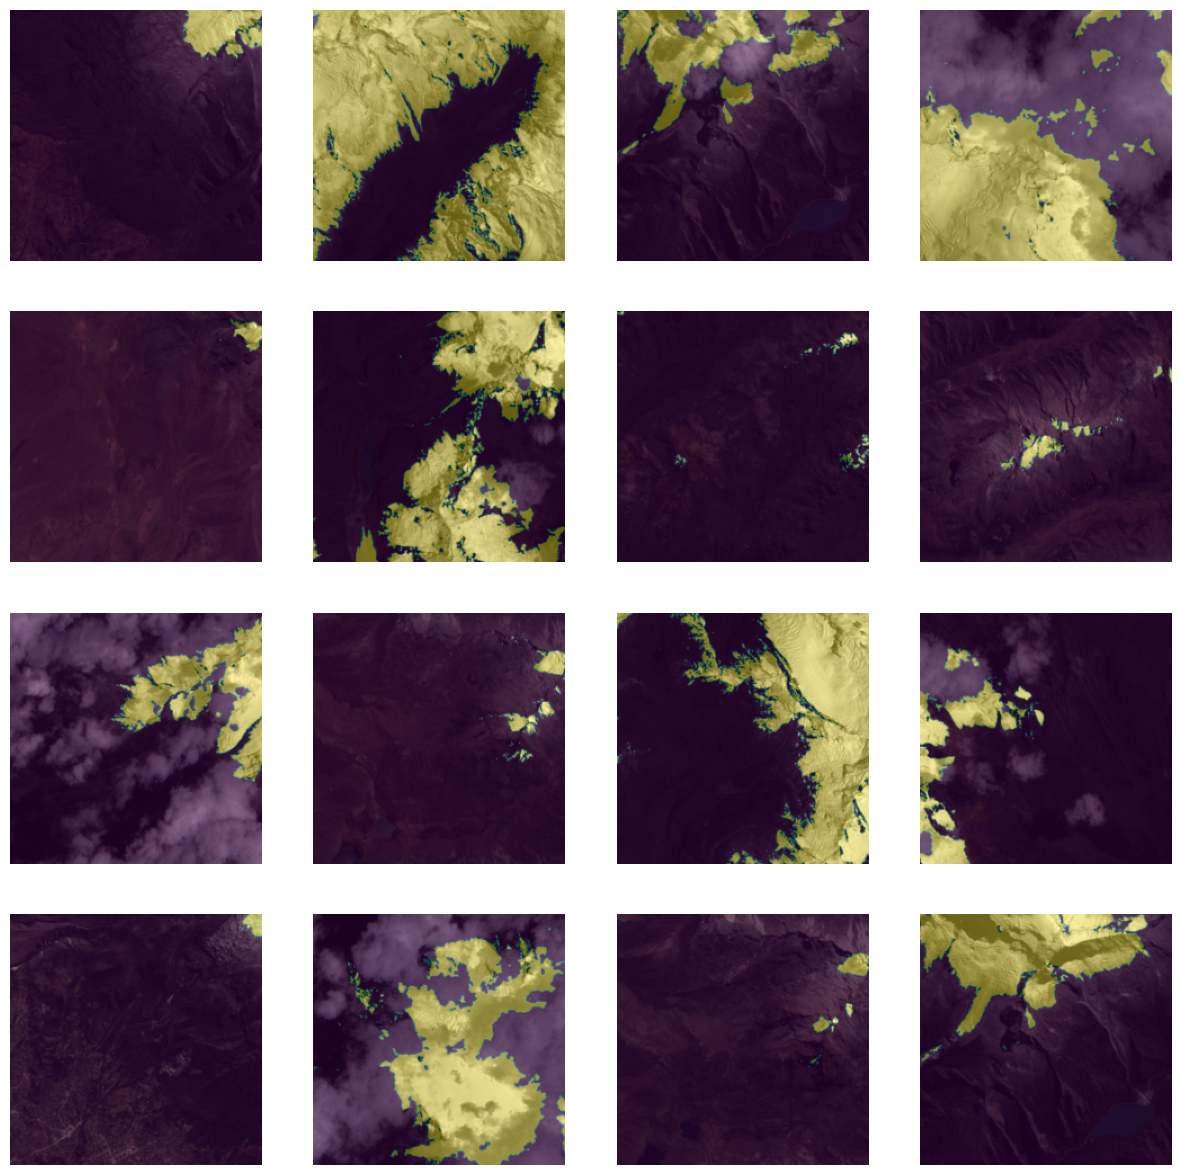

In [66]:
imgs, masks = next(iter(train_loader))
def plot_mini_batch(imgs, masks):
    fig, axs = plt.subplots(4, 4, figsize=(15, 15))
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(imgs[i*4+j].permute(1, 2, 0))
            axs[i, j].imshow(masks[i*4+j].permute(1, 2, 0).squeeze(), alpha=0.4)
            axs[i, j].axis('off')
    plt.show()
plot_mini_batch(imgs, masks)

# Implementación del modelo

### Accuracy

In [67]:
def accuracy(model, loader):
    pass

### Search for Learning Rate

In [68]:
def find_lr(model, optimizer, criterion, train_loader, init_value=1e-8, final_value=10.0):
    pass

### Train loop

In [82]:
def train(model, optimizer, scheduler = None, epochs=100, store_every=25):
    model = model.to(device= device)
    for epoch in epochs:
        train_correct_num = 0
        train_total = 0
        train_cost_acum = 0.
        for mb, (x, y) in enumerate (train_loader, start=1):
            model.train()
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long).squeeze(1)
            scores = model(x)
            cost = F.cross_entropy(scores, y)
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()
            if scheduler: 
                scheduler.step()
            train_predictions = torch.argmax(scores, dim=1)
            train_correct_num += (train_predictions == y).sum()
            train_total += torch.numel(train_predictions)
            train_cost_acum += cost.item()
            if mb % store_every == 0:
                val_cost, val_acc, dice, iou = accuracy(model, val_loader)
                train_acc = float(train_correct_num) / train_total
                train_cost = float(train_cost_acum) / mb
                print(f'Epoch {epoch}, minibatch {mb}, train cost {train_cost:.3f}, train acc {train_acc:.3f}, val cost {val_cost:.3f}, val acc {val_acc:.3f}, dice {dice:.3f}, iou {iou:.3f}')
        # Save model
        #torch.save(model.state_dict(), 'model.pth')

### U-NET model

In [70]:
class Conv_3_kernel(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        # Mantenemos el tamaño de la imagen con padding 1 y stride 1
        self.conv1 = nn.Conv2d(channels_in, channels_out, kernel_size=3, stride=1, padding=1)
    
    def forward(self, x):
        return self.conv1(x)

In [71]:
class Double_Conv(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        # Agregamos batch notmalization para permitir learning rates altos y reducir la dependencia de la inicialización
        self.double_conv = nn.Sequential(
            Conv_3_kernel(channels_in, channels_out),
            nn.BatchNorm2d(channels_out),
            nn.ReLU(),

            Conv_3_kernel(channels_out, channels_out),
            nn.BatchNorm2d(channels_out),
            nn.ReLU()
        )

    def forward(self, x):
        return self.double_conv(x)

In [72]:
class Down_Conv(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        # Reducimos el tamaño de la imagen a la mitad con un kernel de 2 y stride 2
        self.encoder = nn.Sequential(      
            nn.MaxPool2d(kernel_size=2, stride=2),
            Double_Conv(channels_in, channels_out)
        )

    def forward(self, x):
        return self.encoder(x)

In [75]:
# Implementamos el Up_Conv original del paper
class Up_Conv(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        # Aumentamos el tamaño de la imagen a la mitad con un kernel de 2 y stride 2
        self.conv_transpose_layer = nn.ConvTranspose2d(channels_in, channels_out, kernel_size=2, stride=2)
        self.decoder = Double_Conv(channels_in, channels_out)
        
    def forward(self, x1, x2):
        x1 = self.conv_transpose_layer(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.decoder(x)

In [76]:
class Up_Conv_Mejorado(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        # Con upsample y convolución de 1x1 recuperamos las imagenes con mejor resolución y menos ruido, además de reducir la cantidad de canales a la mitad
        self.upsample_layer = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bicubic'),
            nn.Conv2d(channels_in, channels_in//2, kernel_size=1, stride=1)
        )
        self.decoder = Double_Conv(channels_in, channels_out)


    def forward(self, x1, x2):
        """
        x1 = upsampled volume
        x2 = volume from downsample to concatenate
        """
        x1 = self.upsample_layer(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.decoder(x)

In [77]:
class UNET(nn.Module):
    def __init__(self, channels_in, channels, num_classes):
        super().__init__()
        self.firs_conv = Double_Conv(channels_in, channels) # 64, 224, 224
        self.down1 = Down_Conv(channels, channels*2) # 128, 112, 112
        self.down2 = Down_Conv(channels*2, channels*4) # 256, 56, 56
        self.down3 = Down_Conv(channels*4, channels*8) # 512, 28, 28
        
        self.middle = Down_Conv(channels*8, channels*16) # 1024, 14, 14

        self.up1 = Up_Conv_Mejorado(channels*16, channels*8) # 512, 28, 28
        self.up2 = Up_Conv_Mejorado(channels*8, channels*4) # 256, 56, 56
        self.up3 = Up_Conv_Mejorado(channels*4, channels*2) # 128, 112, 112
        self.up4 = Up_Conv_Mejorado(channels*2, channels) # 64, 224, 224

        self.last_conv = nn.Conv2d(channels, num_classes, kernel_size=1, stride=1) # 2, 224, 224

    def forward(self, x):
        x1 = self.firs_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.middle(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.last_conv(x)
        return x

In [80]:
def test():
    model = UNET(3, 64, 2)
    x = torch.randn(16, 3, 224, 224)
    return model(x)
    
preds = test()

In [81]:
print(preds.shape)

torch.Size([16, 2, 224, 224])
